# MNIST - Digit Recognizer

Notebook to classify the MNIST network.

## Import libraries


In [1]:
import matplotlib.pyplot as plt
import random
import time
import os

from IPython import display

from sklearn.utils import shuffle

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Activation, LeakyReLU
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam

from toolkit import write_results, read_preprocessed_dataset

C:\Users\miche\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Set globals

In [2]:
# variable indicating whether to use the splitted datasets (with validation).
SPLITTED = False

DATA_FOLDER = '../../../preprocessed_datasets/splitted/' if SPLITTED else '../../../preprocessed_datasets/full/'
RESULTS_FOLDER = '../Michel/results/'

## Read data

In [ ]:
if SPLITTED:
    X_train, y_train, X_test, X_val, y_val = read_preprocessed_dataset(DATA_FOLDER)
    print('Size X_train: {0}'.format(X_train.shape))
    print('Size y_train: {0}'.format(y_train.shape))
    print('Size X_test: {0}'.format(X_test.shape))
    print('Size X_val: {0}'.format(X_val.shape))
    print('Size y_val: {0}'.format(y_val.shape))

else:
    X_train, y_train, X_test = read_preprocessed_dataset(DATA_FOLDER)
    print('Size X_train: {0}'.format(X_train.shape))
    print('Size y_train: {0}'.format(y_train.shape))
    print('Size X_test: {0}'.format(X_test.shape))

# show (pseudo-)random picture from the training data.
sample_idx = random.randint(0, X_train.shape[0])
sample = X_train[sample_idx]
plt.imshow(sample.reshape((28, 28)), cmap='Greys', interpolation='nearest')
plt.title('Handwritten number {0}'.format(y_train[sample_idx]))
plt.show()

## Find the best network

In [25]:
# set variables
file_dir = './'
network_filepath = os.path.join(file_dir, 'best_model_mnist.h5')

nr_of_classes = y_train.shape[1]
epochs = 100
batch_size = 128
learning_rate = 1e-2
optimizer = Adam(lr=learning_rate)

In [26]:
def conv_model(nr_of_classes):
    inputs = Input(shape=(1, 28, 28))
    
    # layer 1
    x = Conv2D(128, (3, 3), data_format='channels_first')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # layer 2
    x = Conv2D(256, (3, 3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # layer 3
    x = Conv2D(512, (3, 3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, kernel_initializer='he_normal')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.4)(x)

    predictions = Dense(nr_of_classes, kernel_initializer='he_normal', activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    print(model.summary())
    return model

In [27]:
# compile
model = conv_model(nr_of_classes)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy']
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 26, 26)       1280      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 26, 26)       104       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 128, 26, 26)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 26, 26)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 13, 26)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 62, 11, 256)       60160     
__________

### Learning procedure

In [28]:
def train_network(network, X_train, y_train, X_val, y_val, epochs, batch_size, network_filepath):
    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy
    
    for epoch in range(epochs):
        st = time.time()

        # Train your network
        results = network.fit(X_train, y_train, batch_size=batch_size)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(X_val, y_val, batch_size=batch_size)     
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = max(val_accs)
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt], 
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

Scores:

without dropout, lr = 0.0005 -> 98.48

dropout - between all layers 0.2 -> 98.45

dropout- all 0.2, last 0.4 - 0.15% test -> 98.41


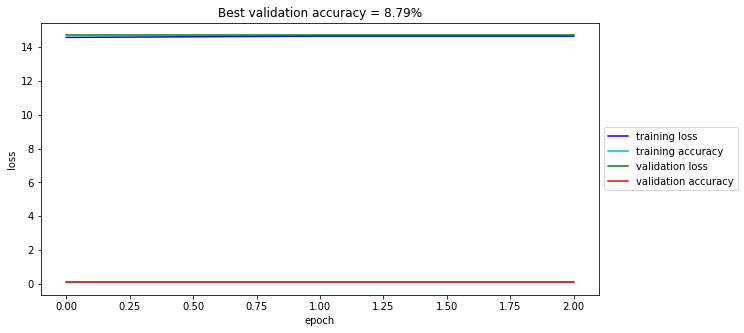

Epoch 1/1
18432/35700 [==============>...............] - ETA: 1:00 - loss: 14.6717 - acc: 0.0897

In [ ]:
train_network(model, X_train, y_train, X_val, y_val, epochs, batch_size, network_filepath)

# Classification

## Train the full network

In [33]:
# use the total training set again
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

# shuffle the data sets
X_train, y_train = shuffle(X_train, y_train)

# train the best model

# best_network.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

### Test set classification

In [26]:
best_network = load_model(network_filepath)
predictions = best_network.predict(X_test)
predictions = [np.argmax(sample_scores) for sample_scores in predictions]
# 98,81 on validation
# write to the results folder
write_results(predictions, RESULTS_FOLDER, 'conv_jup2_results')